In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier



In [4]:
# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Save Loan_IDs
test_ids = test_df["Loan_ID"]

# Drop Loan_IDs
train_df.drop("Loan_ID", axis=1, inplace=True)
test_df.drop("Loan_ID", axis=1, inplace=True)

# Feature Engineering
for df in [train_df, test_df]:
    df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
    df["LoanIncomeRatio"] = df["LoanAmount"] / (df["TotalIncome"] + 1)
    df["IncomeBins"] = pd.qcut(df["TotalIncome"], 4, labels=False)

# Define features and target
features = ['Gender','Married','Dependents','Education','Self_Employed',
            'ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term',
            'Credit_History','Property_Area', 'TotalIncome', 'LoanIncomeRatio', 'IncomeBins']
target = 'Loan_Status'

X = train_df[features]
y = train_df[target].map({'Y': 1, 'N': 0})
X_test = test_df[features]



In [5]:
# Column types
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                  'Credit_History', 'TotalIncome', 'LoanIncomeRatio', 'IncomeBins']
categorical_cols = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']



In [6]:
# Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Final Model Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42))
])



In [7]:
# Fit model
model.fit(X, y)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print(f"Cross-validated F1 Score: {cv_scores.mean():.4f}")

# Predict probabilities
y_proba_train = model.predict_proba(X)[:, 1]

# F-beta threshold tuning (β=0.5 prefers precision)
beta = 0.5
precisions, recalls, thresholds = precision_recall_curve(y, y_proba_train)
fbeta_scores = [( (1 + beta**2) * p * r ) / ((beta**2 * p) + r + 1e-8) for p, r in zip(precisions[:-1], recalls[:-1])]
best_index = np.argmax(fbeta_scores)
best_threshold = thresholds[best_index]
print(f"\nBest threshold using F-beta (β={beta}): {best_threshold:.3f}")

# Classification on train using threshold
y_pred_balanced = (y_proba_train >= best_threshold).astype(int)
print("\nClassification Report (Threshold Adjusted):")
print(classification_report(y, y_pred_balanced))



C:\Users\Win11\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Win11\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Win11\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Win11\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:52] WARNING: C:\actio

Cross-validated F1 Score: 0.8608

Best threshold using F-beta (β=0.5): 0.734

Classification Report (Threshold Adjusted):
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       192
           1       0.99      0.93      0.96       422

    accuracy                           0.95       614
   macro avg       0.93      0.96      0.94       614
weighted avg       0.95      0.95      0.95       614



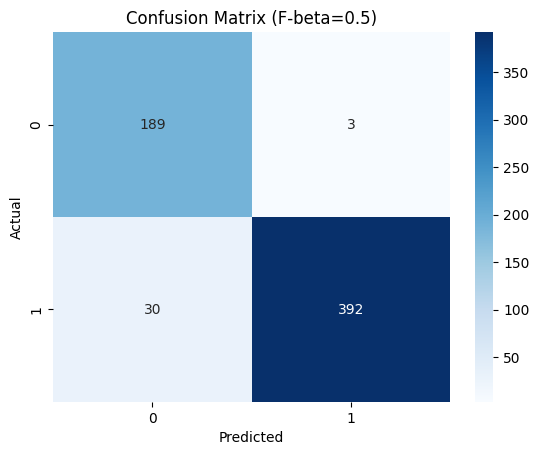

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,N


In [8]:
# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred_balanced)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (F-beta={beta})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Predict on Test using threshold
y_proba_test = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_proba_test >= best_threshold).astype(int)

# Prepare Submission
submission = pd.DataFrame({
    "Loan_ID": test_ids,
    "Loan_Status": np.where(y_test_pred == 1, 'Y', 'N')
})

# Save if needed
# submission.to_csv("submission_balanced_threshold.csv", index=False)
submission.head()